In [19]:
import sys
sys.path.append('../')
import joblib

from Modules.Utils.Imports import *
from Modules.Models.BuildBINNs import AdaMaskBINNCovasim
from Modules.Utils.ModelWrapper import ModelWrapper

import Modules.Utils.PDESolver as PDESolver
import Modules.Loaders.DataFormatter as DF
from utils import get_case_name

In [20]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))
# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

Device set to cpu


In [21]:
# instantiate BINN model parameters and path
path = '../Data/covasim_data/drums_data/'
# path = '../Data/covasim_data/xin_data/'

# data parameters
population = int(500e3)
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
masking = 0
multiple = True
parallelb = True
n_runs = 64
chi_type = 'piecewise'

# model parameters
maskb = False
masking_learned = False

case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)

In [22]:
if not masking==0:
    if masking==1:
        case_name = case_name + '_maskingdem'
    elif masking==2:
        case_name = case_name + '_maskinguni'
    elif masking==3:
        case_name = case_name + '_maskingnorm'

if multiple:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name + '_' + str(n_runs), plot=False)
else:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name, plot=False)

In [23]:
# multiple==True and parallelb==False means that data is a list and not normalized
if multiple and not parallelb:
    data = np.mean(params['data'], axis=0)
    data = (data / params['population'])
    avg_masking = np.mean(params['avg_masking'], axis=0)
    avg_masking = (avg_masking / params['population'])
# multiple==True and parallelb==True means that the data is a 2d array and normalized
elif multiple and parallelb:
    data = params['data'] # parallel simulations store normalized data
    avg_masking = params['avg_masking']
# otherwise, the data is from a single simulation and is not normalized
else:
    data = params['data']
    data = (data / params['population']).to_numpy()
    avg_masking = params['avg_masking']
    avg_masking = (avg_masking / params['population'])
    
params.pop('data')

N = len(data)
t_max = N - 1
t = np.arange(N)[:,None]

tracing_array = params['tracing_array']

In [24]:
model_path = '../models/covasim'
if maskb:
    model_path += '/mask'
    if masking_learned:
        model_path += '/learned_masking'
    else:
        model_path += '/observed_masking'
else:
    model_path += '/no_mask'

In [25]:
#--------------------no masking----------------------#
# model_folder = '/2023-07-20_17-53-03' # no masking, 500e3 pop, dynamic piecewise, 64 avg., 800e3 epochs, lr=1e-5
# model_folder = '/2023-07-21_18-42-24' # no masking, 500e3 pop, dynamic piecewise, 64 avg., 1e6 epochs, lr=1e-6
model_folder = '/2023-07-22_10-20-01' # no masking, 500e3 pop, dynamic piecewise, 64 avg., 1e6 epochs, lr=5e-6
# model_folder = '/2023-07-23_00-48-24' # no masking, 500e3 pop, dynamic piecewise, 64 avg., 1e6 epochs, lr=9e-6

#------------------normal masking--------------------#
# model_folder = '/2023-07-20_18-13-01' # masking-norm, observed M, 500e3, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-21_18-41-30' # masking-norm, observed M, 500e3, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-21_21-48-16' # masking-norm, observed M, 500e3, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-22_10-16-47' # masking-norm, observed M, 500e3, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-22_12-40-47' # masking-norm, observed M, 500e3, dynamic piecewise, 64 avg., 800e3, lr=5e-5
# model_folder = '/2023-07-23_00-27-07' # masking-norm, observed M, 500e3, dynamic piecewise, 64 avg., 800e3, lr=5e-5

#---------------demographic masking------------------#
# model_folder = '/2023-07-20_22-20-10' # masking-dem, observed M, 500e3, dynamic piecewise, 64 avg., 600e3, lr=5e-5

mydir = model_path + model_folder

In [26]:
# mydir = '../models/covasim/mask/2023-07-13_23-46-11' # norm masking, 200e3 pop, dynamic piecewise, keepd, 1024 avg., 200,000 epochs, lr=1e-4
# mydir = '../models/covasim/mask/2023-07-15_10-53-32' # norm masking, 200e3 pop, dynamic piecewise, keepd, 1024 avg., 500,000 epochs, lr=9e-5
# mydir = '../models/covasim/mask/2023-07-15_16-24-50' # norm masking, 200e3 pop, dynamic piecewise, keepd, 1024 avg., 500,000 epochs, lr=5e-5, deep eta, beta
# mydir = '../models/covasim/mask/2023-07-15_22-46-45' # norm masking, 200e3 pop, dynamic piecewise, keepd, 1024 avg., 600,000 epochs, lr=5e-5, deep eta, beta, tau
# mydir = '../models/covasim/mask/2023-07-16_16-48-08' # norm masking, 500e3 pop, dynamic piecewise, keepd, 2048 avg., 800,000 epochs, lr=5e-5, deep eta, beta
# mydir = '../models/covasim/no_mask/2023-07-18_18-53-36' # no masking, 500e3 pop, dynamic piecewise, keepd, 64 avg., 500,000 epochs, lr=5e-5, deep eta, beta, tau_bounds = [0.05, 0.15]

In [9]:
yita_lb = 0.0
yita_ub = 1.0
beta_lb = 0.0
beta_ub = 0.5
tau_lb = 0.05
tau_ub = 0.4
eta_deep = True
beta_deep = True
tau_deep = False

In [10]:
binn = AdaMaskBINNCovasim(params, 
                t_max_real=t_max, 
                tracing_array=tracing_array, 
                yita_lb=None, 
                yita_ub=None,
                beta_lb=None,
                beta_ub=None,
                tau_lb=tau_lb,
                tau_ub=tau_ub, 
                chi_type=chi_type,
                eta_deep=eta_deep,
                beta_deep=beta_deep,
                tau_deep=tau_deep,
                maskb=maskb,
                masking_learned=masking_learned).to(device)
parameters = binn.parameters()
model = ModelWrapper(binn, None, None, save_name=os.path.join(mydir, case_name))

In [11]:
# load model weights
# model.save_name = '../Weights/'
# model.save_name += case_name
if retrain:
    model.save_name += '_retrain'
model.save_name += '_best_val'
model.load(model.save_name + '_model', device=device)
save_path = model.save_folder
# grab initial condition
u0 = data[0, :].copy()

In [12]:
# if not folder for plots exists, make them
if not os.path.exists(model.save_folder + '/eta_plots'):
    os.makedirs(os.path.join(model.save_folder, 'eta_plots'))
    os.makedirs(os.path.join(model.save_folder, 'beta_plot'))
    os.makedirs(os.path.join(model.save_folder, 'tau_plot'))
    os.makedirs(os.path.join(model.save_folder, 'lasso_plots'))

In [13]:
# grab value ranges
yita_lb, yita_ub = model.model.yita_lb, model.model.yita_ub
beta_lb, beta_ub = model.model.beta_lb, model.model.beta_ub
tau_lb, tau_ub = model.model.tau_lb, model.model.tau_ub

In [14]:
# learned contact_rate function
def contact_rate(u):
    res = binn.eta_func(to_torch(u))
    return to_numpy(res)

# learned effective tracing rate function
def beta(u):
    res = binn.beta_func(to_torch(u))
    return to_numpy(res)

# learned diagnosis of quarantined rate function
def tau(u):
    res = binn.tau_func(to_torch(u))
    return to_numpy(res)

In [15]:
#%% visualization for eta
s_min, s_max = data[:,0].min(), data[:,0].max()
a_min, a_max = data[:,3].min(), data[:,3].max()
y_min, y_max = data[:,4].min(), data[:,4].max()
if masking > 0:
    m_min, m_max = avg_masking.min(), avg_masking.max()
say_min, say_max = (data[:,0] + data[:,3] + data[:,4]).min(), (data[:,0] + data[:,3] + data[:,4]).max()
chi_min, chi_max = 0.0, params['eff_ub']

C:\Users\Teddy\AppData\Local\Temp\ipykernel_18920\3920399784.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(pad=2)


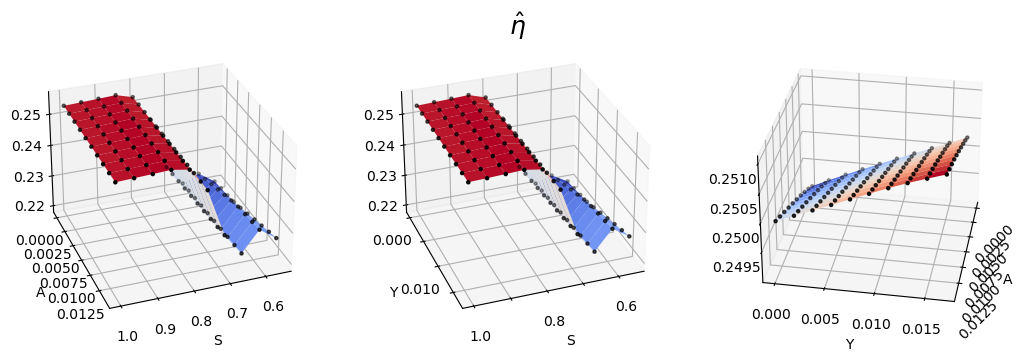

In [16]:
if masking > 0:   
    # grid for inputs S, A
    a_grid = np.linspace(s_min, s_max, 10)
    # grid for inputs S, Y
    b_grid = np.linspace(a_min, a_max, 10)
    # grid for inputs A, Y
    c_grid = np.linspace(y_min, y_max, 10)
    # grid for inputs with M
    d_grid = np.linspace(m_min, m_max, 10)

    labels = ['S', 'A', 'Y', 'M']
    fig = plt.figure(figsize=(10,7))
    fig.suptitle('$\hat{\eta}$', y=0.83, size=18)
    # for each of the 3 input combinations
    for i in range(6):
        if i == 0:
            X, Y = np.meshgrid(a_grid, b_grid)
            Z, M = np.ones_like(X) * c_grid.mean(), np.ones_like(X) * d_grid.mean()
            # set x and y labels to S and A
            x_label, y_label = labels[0], labels[1]
        elif i == 1:
            X, Z = np.meshgrid(a_grid, c_grid)
            Y, M = np.ones_like(X) * b_grid.mean(), np.ones_like(X) * d_grid.mean()
            # set x and y labels to S and Y
            x_label, y_label = labels[0], labels[2]
        elif i==2:
            Y, Z = np.meshgrid(b_grid, c_grid)
            X, M = np.ones_like(Y) * a_grid.mean(), np.ones_like(Y) * d_grid.mean()
            # set x and y labels to A and Y
            x_label, y_label = labels[1], labels[2]
        elif i==3:
            X, M = np.meshgrid(a_grid, d_grid)
            Y, Z = np.ones_like(X) * b_grid.mean(), np.ones_like(X) * c_grid.mean()
            # set x and y labels to S and M
            x_label, y_label = labels[0], labels[3]
        elif i==4:
            Y, M = np.meshgrid(b_grid, d_grid)
            X, Z = np.ones_like(Y) * a_grid.mean(), np.ones_like(Y) * c_grid.mean()
            # set x and y labels to A and M
            x_label, y_label = labels[1], labels[3]
        elif i==5:
            Z, M = np.meshgrid(c_grid, d_grid)
            X, Y = np.ones_like(Z) * a_grid.mean(), np.ones_like(Z) * b_grid.mean()
            # set x and y labels to S and M
            x_label, y_label = labels[2], labels[3]

        # grid of S, A, Y values
        u_grid = np.stack([np.ravel(X), np.ravel(Y), np.ravel(Z), np.ravel(M)], axis=1)
        # result of evaluating eta with inputs S, A, Y
        res = contact_rate(u_grid)
        # transfom eta(S, A, Y) into the interval previously defined
        res = yita_lb + (yita_ub - yita_lb) * res
        res = res[:,0].reshape(X.shape)
        res = np.round(res, decimals=6)
        
        ax = fig.add_subplot(2, 3, i + 1, projection='3d')
        if i==0:
            ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
            ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
            ax.view_init(30,70)
        elif i==1:
            ax.plot_surface(X, Z, res, cmap=cm.coolwarm, alpha=1)
            ax.scatter(X.reshape(-1), Z.reshape(-1), res.reshape(-1), s=5, c='k')
            ax.view_init(30,70)
        elif i==2:
            ax.plot_surface(Y, Z, res, cmap=cm.coolwarm, alpha=1)
            ax.scatter(Y.reshape(-1), Z.reshape(-1), res.reshape(-1), s=5, c='k')
            for label in ax.get_xticklabels()[::2]:
                label.set_visible(False)
            for label in ax.get_yticklabels()[::2]:
                label.set_visible(False)
            #plt.setp(ax.get_xticklabels(), rotation=45) # , ha="right", rotation_mode="anchor"
            ax.view_init(30,10)
        elif i==3:
            ax.plot_surface(X, M, res, cmap=cm.coolwarm, alpha=1)
            ax.scatter(X.reshape(-1), M.reshape(-1), res.reshape(-1), s=5, c='k')
            ax.view_init(30,70)
        elif i==4:
            ax.plot_surface(Y, M, res, cmap=cm.coolwarm, alpha=1)
            ax.scatter(Y.reshape(-1), M.reshape(-1), res.reshape(-1), s=5, c='k')
            ax.view_init(30,70)
        elif i==5:
            ax.plot_surface(Z, M, res, cmap=cm.coolwarm, alpha=1)
            ax.scatter(Z.reshape(-1), M.reshape(-1), res.reshape(-1), s=5, c='k')
            for label in ax.get_xticklabels()[::2]:
                label.set_visible(False)
            for label in ax.get_yticklabels()[::2]:
                label.set_visible(False)
            ax.view_init(30,70)

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        
    plt.tight_layout(pad=3.5)
    plt.savefig(os.path.join(save_path + '/eta_plots', case_name + '_parameter_NN_eta_DRUMS' + '.png'), dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()
else:
    # grid for inputs S, A
    a_grid = np.linspace(s_min, s_max, 10)
    # grid for inputs S, Y
    b_grid = np.linspace(a_min, a_max, 10)
    # grid for inputs A, Y
    c_grid = np.linspace(y_min, y_max, 10)

    labels = ['S', 'A', 'Y']
    fig = plt.figure(figsize=(10,7))
    fig.suptitle('$\hat{\eta}$', y=0.75, size=18)
    # for each of the 3 input combinations
    for i in range(3):
        if i == 0:
            X, Y = np.meshgrid(a_grid, b_grid)
            Z = np.ones_like(X) * c_grid.mean()
            # set x and y labels to S and A
            x_label, y_label = labels[0], labels[1]
        elif i == 1:
            X, Z = np.meshgrid(a_grid, c_grid)
            Y = np.ones_like(X) * b_grid.mean()
            # set x and y labels to S and Y
            x_label, y_label = labels[0], labels[2]
        else:
            Y, Z = np.meshgrid(b_grid, c_grid)
            X = np.ones_like(Y) * a_grid.mean()
            for label in ax.get_xticklabels()[::2]:
                label.set_visible(False)
            for label in ax.get_yticklabels()[::2]:
                label.set_visible(False)
            # set x and y labels to A and Y
            x_label, y_label = labels[1], labels[2]

        # grid of S, A, Y values
        u_grid = np.stack([np.ravel(X), np.ravel(Y), np.ravel(Z)], axis=1)
        # result of evaluating eta with inputs S, A, Y
        res = contact_rate(u_grid)
        # transfom eta(S, A, Y) into the interval previously defined
        res = yita_lb + (yita_ub - yita_lb) * res
        res = res[:,0].reshape(X.shape)
        res = np.round(res, decimals=6)
        
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')
        if i == 0:
            ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
            ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
            ax.view_init(30,70)
        elif i == 1:
            ax.plot_surface(X, Z, res, cmap=cm.coolwarm, alpha=1)
            ax.scatter(X.reshape(-1), Z.reshape(-1), res.reshape(-1), s=5, c='k')
            ax.view_init(30,70)
        else:
            ax.plot_surface(Y, Z, res, cmap=cm.coolwarm, alpha=1)
            ax.scatter(Y.reshape(-1), Z.reshape(-1), res.reshape(-1), s=5, c='k')
            plt.setp(ax.get_xticklabels(), rotation=45) # , ha="right", rotation_mode="anchor"
            ax.view_init(30,10)

        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    
    plt.tight_layout(pad=2)
    plt.savefig(os.path.join(save_path + '\\eta_plots', case_name + '_parameter_NN_eta_DRUMS' + '.png'), dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()

C:\Users\Teddy\AppData\Local\Temp\ipykernel_18920\3361611165.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(pad=2)


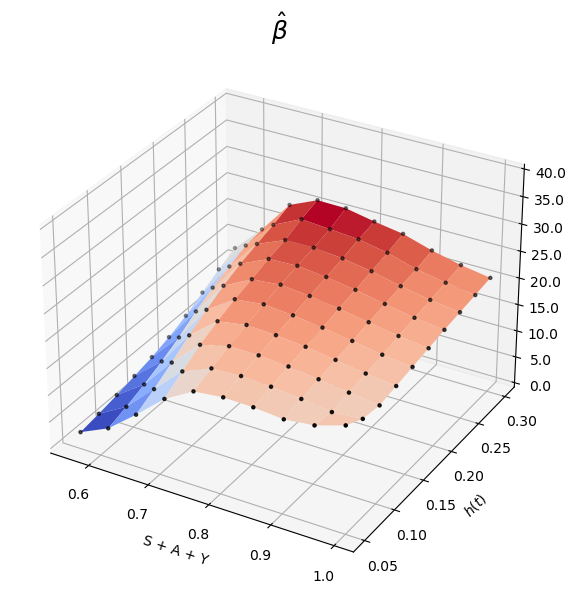

In [17]:
#%% visualization for beta
chi_min, chi_max = 0.05, params['eff_ub']
# chi_grid = np.linspace(chi_min, chi_max, 10)

a_grid = np.linspace(say_min, say_max, 10) # S + A + Y
b_grid = np.linspace(chi_min, chi_max, 10)
labels = ['S + A + Y', r'$h(t)$']

X, Y = np.meshgrid(a_grid, b_grid)
x_label, y_label = labels[0], labels[1]
u_grid = np.stack([np.ravel(X), np.ravel(Y)], axis=1)
res = beta(u_grid) * params['n_contacts'] # * u_grid[:, [1]] *
res = res[:,0].reshape(X.shape)
res = np.round(res, decimals=6)
# res = beta_lb + (beta_ub - beta_lb) * res

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_zticks(np.arange(0,40.1, 5), np.arange(0,40.1, 5))
ax.set_title(r'$\hat{\beta}$', size=18)
plt.tight_layout(pad=2)

plt.savefig(os.path.join(save_path + '/beta_plot', case_name + '_parameter_NN_beta_DRUMS' + '.png'), dpi=400, bbox_inches='tight' )
plt.show()
plt.close()

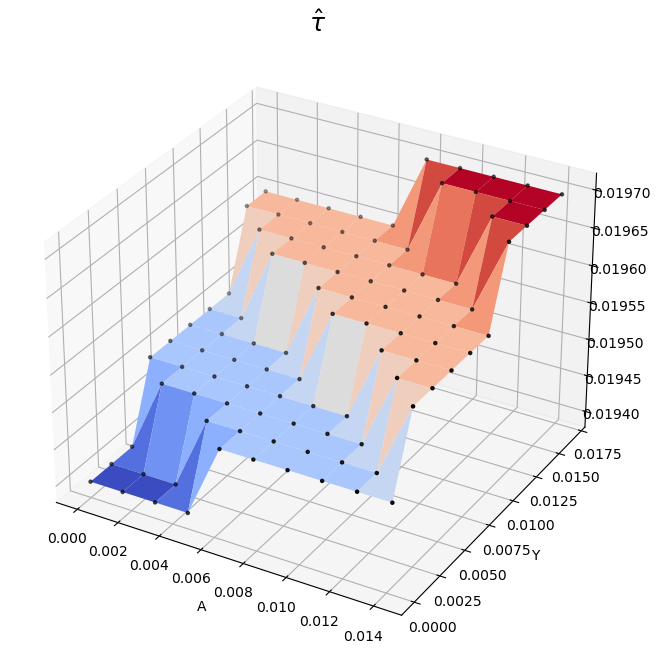

In [18]:
#%% visualization for tau
a_grid = np.linspace(a_min, a_max, 10)
b_grid = np.linspace(y_min, y_max, 10)
labels = ['A', 'Y']

X, Y = np.meshgrid(a_grid, b_grid)
x_label, y_label = labels[0], labels[1]
u_grid = np.stack([np.ravel(X), np.ravel(Y)], axis=1)
res = tau(u_grid)
res = res[:,0].reshape(X.shape)
res = tau_lb + (tau_ub - tau_lb) * res # scaling
res = np.round(res, decimals=4)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_surface(X, Y, res, cmap=cm.coolwarm, alpha=1)
ax.scatter(X.reshape(-1), Y.reshape(-1), res.reshape(-1), s=5, c='k')
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title(r'$\hat{\tau}$', size=18)
plt.tight_layout(pad=2)
plt.savefig(os.path.join(save_path + '/tau_plot', case_name + '_parameter_NN_tau_DRUMS' + '.png'), dpi=400, bbox_inches='tight')
plt.show()
plt.close()

***
### Loading Sparse Regression Estimates

In [21]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# load the LASSO dictionaries for each parameter with the specifc number of nonzero component coefficients
eta_ld = joblib.load(model.save_folder + '/eta_eq_coef/' + case_name + '_' + str(n_runs) + '_sparse_coef_6comps')
beta_ld = joblib.load(model.save_folder + '/beta_eq_coef/' + case_name + '_' + str(n_runs) + '_sparse_coef_6comps')
tau_ld = joblib.load(model.save_folder + '/tau_eq_coef/' + case_name + '_' + str(n_runs) + '_sparse_coef_1comps')

In [22]:
poly = PolynomialFeatures(2)
all_data = np.concatenate((data, avg_masking[:,None]), axis=1)
X = poly.fit_transform(all_data)

eta_coef = np.append(eta_ld['Lasso'].intercept_, eta_ld['Lasso'].coef_)
beta_coef = np.append(beta_ld['Lasso'].intercept_, beta_ld['Lasso'].coef_)
tau_coef = np.append(tau_ld['Lasso'].intercept_, tau_ld['Lasso'].coef_)